In [22]:
#Import Libraries
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
from collections import OrderedDict
import torch.optim as optim
import numpy as np
from PIL import Image

In [23]:
#Specify transforms
import torchvision.transforms as transforms
train_transformations = transforms.Compose([
    transforms.Resize((224)),
    transforms.CenterCrop((224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
#Load in each dataset and apply transformations specified above
import torchvision.datasets as datasets
train_set = datasets.ImageFolder("flower_data/train", transform = train_transformations)
val_set = datasets.ImageFolder("flower_data/valid", transform = val_transformations)

#Put into a Dataloader
import torch
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =1, shuffle=True)

In [25]:
#Get pretrained model
import torchvision.models as models
model = models.densenet161(pretrained=True)

#Turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False

#Create new classifier for model
import torch.nn as nn
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(2208, 1024)),
            ('relu1', nn.ReLU()),
            ('fc2', nn.Linear(1024, 512)),
            ('relu2', nn.ReLU()),
            ('fc3', nn.Linear(512, 102)),
            ('output', nn.LogSoftmax(dim=1))
        ]))

model.classifier = classifier

#load parameters that I trained
state_dict = torch.load('model.pt')
model.load_state_dict(state_dict)

/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [26]:
# Find the device available to use (GPU is faster but if not, CPU could work)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Set the error function
criterion = nn.NLLLoss()


#Set the optimizer function
import torch.optim as optim
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)


#Move model to the device specified above
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [ ]:
#TRAIN
import numpy as np
valid_loss_min = np.inf
epochs = 10
for epoch in range(epochs):
    running_loss = 0
    val_loss = 0
    accuracy = 0

    #Start training the model
    #Set model to train mode
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        #Clear optimizers
        optimizer.zero_grad()
        #Forward pass
        output = model.forward(inputs)
        #Loss
        loss = criterion(output, labels)
        #Calculate gradients (backpropogation)
        loss.backward()
        #Adjust parameters based on gradients
        optimizer.step()
        #Add the loss to the training set's running loss
        running_loss += loss.item()*inputs.size(0)
        
        counter += 1
        print(counter, "/", len(train_loader))
        
    #Evaluate the model
    #Set model to evaluation mode
    model.eval()
    count = 0
    #Tell torch not to calculate grads
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            #Forward pass
            output = model.forward(inputs)
            #Calculate Loss
            valloss = criterion(output, labels)
            #Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            #Since our model outputs a LogSoftmax, find the real percentages
            output = torch.exp(output)
            #Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)
            #See how many of the classes were correct
            equals = top_class == labels.view(*top_class.shape)
            #Calculate the mean (get the accuracy for this batch) and add it to the 
            #running accuracy for this epoch
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            count += 1
            print(count, "/", len(val_loader))
    
    #Get the average loss for the epoch
    train_loss = running_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)
    #Print out data
    print('Accuracy: ', accuracy/len(val_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    #Save the model if the validation loss this time is less than the validation loss last time
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

In [27]:
#Set dictionary for mapping label to name of specied
species = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted class is:  102
The model is  99.91334676742554 % certain that the flower is a blackberry lily


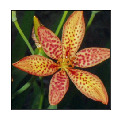

In [28]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


model.eval()
output_to_class = {v: k for k, v in val_set.class_to_idx.items()}

def process_image(image_path):
    #Load Image    
    img = Image.open(image_path)
    #Get the dimensions of the image
    width, height = img.size
    # Resize by keeping the aspect ratio and the dimension of only the shorter size is changed to 255
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    #Get the dimensions of the new image size
    width, height = img.size
    #Set the coordinates to do a center crop of 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    #Turn image into numpy array
    img = np.array(img)
    #Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    #Make all values between 0 and 1
    img = img/255
    #Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    #Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    #Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

def predict(image, model):
    output = model.forward(image)
    output = torch.exp(output)
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

image = process_image("flower_data/valid/102/image_08041.jpg")
top_prob, top_class = predict(image, model)
label = output_to_class[top_class]
flower = species[str(label)]

image = image.numpy() # convert images to numpy for display
fig = plt.figure(figsize=(25, 4))
ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
image[0] = image[0] * 0.226 + 0.445
plt.imshow(np.transpose(image[0], (1, 2, 0)))

    
print("Predicted class is: ",label)
print("The model is ", top_prob*100, "% certain that the flower is a", flower)